In [1]:
import torch

from einops import rearrange

from pathlib import Path

import pandas as pd

import numpy as np

from matplotlib import pyplot as plt

import seaborn as sns
from itertools import islice

from data_util.data import Vocab
from data_util import config

import matplotlib.ticker as ticker

/home/dani/uva/dl4nlp/pointer_summarizer/.env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dani/uva/dl4nlp/pointer_summarizer/.env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dani/uva/dl4nlp/pointer_summarizer/.env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dani/uv

In [2]:
sns.set(font_scale=2, style='whitegrid')

In [3]:
input_path = Path('bayes-glelmo')

In [4]:
sentence_offset = 16
sentence_length = 20

In [5]:
results = [f for f in input_path.iterdir() if f.is_file()]

In [6]:
results

[PosixPath('bayes-glelmo/101.pt'),
 PosixPath('bayes-glelmo/100.pt'),
 PosixPath('bayes-glelmo/69.pt')]

In [7]:
result = torch.load(results[2], map_location=torch.device('cpu'))

In [8]:
def convert_experiment_to_df(result, vocab, sentence_offset=0, sentence_length=None):
    all_res = []
    words = []
    print(sentence_offset, sentence_length)
    print(list(result.keys())[sentence_offset:sentence_offset+sentence_length])
    for i, r in list(result.items())[sentence_offset:sentence_offset+sentence_length]:
        res = r
        res = rearrange(res, 'word batch prob -> (word batch) prob')
        m = int(res.max(1).indices[0])
        
        all_res.append(list(res[:, m].cpu().numpy()))

        m = 1 if m not in vocab._id_to_word else m
        word = vocab.id2word(m).decode('utf-8')
        
        words.append(word)

    all_res = np.array(all_res).T
    
    # df = pd.DataFrame(data=all_res,columns=words)
    df = all_res
    return df, words

In [9]:
vocab = Vocab(config.vocab_path, config.vocab_size)

max_size of vocab was specified as 50000; we now have 50000 words. Stopping reading.
Finished constructing vocabulary of 50000 total words. Last word added: b'chaudhary'


In [10]:
experiment_df, words = convert_experiment_to_df(result, vocab, sentence_offset=sentence_offset, sentence_length=sentence_length)

16 20
[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


In [11]:
len(words)

20

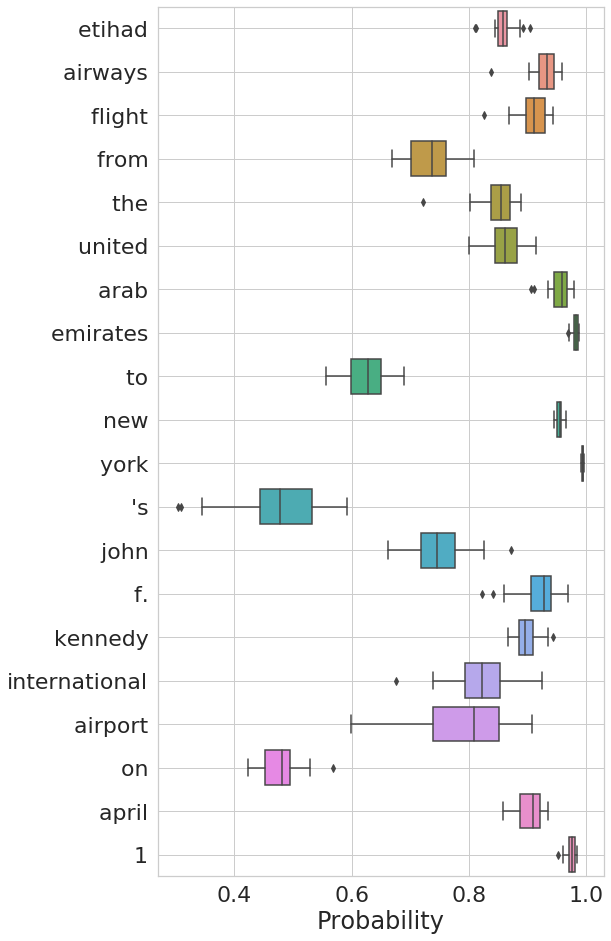

In [12]:
# plt.style.use(['default', 'seaborn-paper'])

plt.subplots(figsize=(8, len(words)*0.8))
# sns.set_style("darkgrid")

# sns.set(style="whitegrid", rc={'figure.figsize': (8, 15)})
ax = sns.boxplot(data=experiment_df, orient='h')
# sns.set_style('darkgrid')

# t = ax.set_xticklabels([textwrap.fill(t.get_text(), 10)  for t in ax.get_xticklabels()
# t = ax.set_xticklabels([textwrap.fill(w, 10)  for w in words], rotation=60)
# m = ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
# m = ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

ax.yaxis.grid(True)
ax.xaxis.grid(True)
t = ax.set_yticklabels(['{0: >10}'.format(w) for w in words])
ax.set(xlabel='Probability')

# xticks = ax.set_xticklabels(labels=words)
out = 'figures'
Path(out).mkdir(exist_ok=True, parents=True)
out_file = Path(out) / 'bayesian_box.eps'
out_file = str(out_file)

plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file + '.png', bbox_inches='tight')